In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import *
import seaborn as sns
import scipy.stats
from matplotlib.lines import Line2D
import matplotlib as mpl
from mquad.mquad_utils import findKnee

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

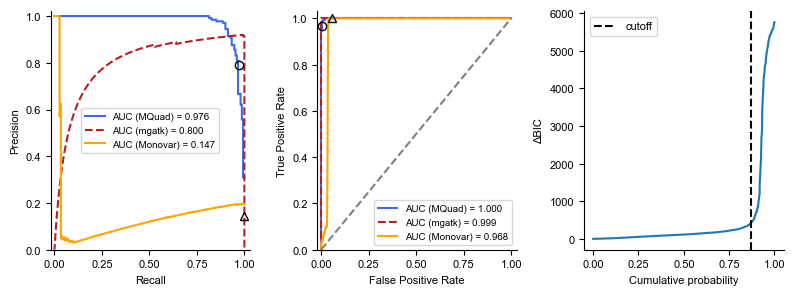

In [33]:
mquad = process_mquad_data(50,10)
mgatk = process_mgatk_data(50,10)
merged_with_mquad = process_monovar_data(50,10)

fpr_mquad, tpr_mquad, auc_mquad, precision_mquad, recall_mquad, aps_mquad = calculate_metrics(mquad.truth, mquad.deltaBIC)
fpr_mgatk, tpr_mgatk, auc_mgatk, precision_mgatk, recall_mgatk, aps_mgatk = calculate_metrics(mgatk.truth, mgatk.vmr)
fpr_mono, tpr_mono, auc_mono, precision_mono,recall_mono, aps_mono = calculate_metrics(merged_with_mquad.truth, merged_with_mquad.MPR)

def plot_figure_1b():
    plt.plot(recall_mquad, precision_mquad, 'royalblue', label = 'AUC (MQuad) = %0.3f' % aps_mquad)
    p_mgatk,r_mgatk = PR_curve(mgatk.truth, mgatk.vmr)
    plt.plot(r_mgatk, p_mgatk, 'firebrick', linestyle='--', label = 'AUC (mgatk) = %0.3f' % aps_mgatk)
    plt.plot(recall_mono, precision_mono, 'orange', label = 'AUC (Monovar) = %0.3f' % aps_mono)
    plt.plot(0.97, 0.79, marker='o', fillstyle='none', color='black')
    plt.plot(1.0, 0.144, marker='^', fillstyle='none', color='black')
    plt.legend(loc='center', prop={'size': 7})
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.xlim([-0.02, 1.03])
    plt.ylim([0, 1.02])

def plot_figure_1c():
    plt.plot(fpr_mquad, tpr_mquad, 'royalblue', label = 'AUC (MQuad) = %0.3f' % auc_mquad)
    plt.plot(fpr_mgatk, tpr_mgatk, 'firebrick', linestyle='--', label = 'AUC (mgatk) = %0.3f' % auc_mgatk)
    plt.plot(fpr_mono, tpr_mono, 'orange', label = 'AUC (Monovar) = %0.3f' % auc_mono)
    plt.plot(38/(16023+38), 145/150, marker='o', fillstyle='none', color='black')
    plt.plot(895/(15166+895), 1, marker='^', fillstyle='none', color='black')
    plt.legend(loc='lower right',  prop={'size': 7})
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.plot([0, 1], [0, 1],'--', color='grey')
    plt.xlim([-0.02, 1.03])
    plt.ylim([0, 1.03])

def plot_figure_1d():
    x,y,knee_x, knee_y = findKnee(mquad.deltaBIC)
    plt.plot(x, y)
    plt.axvline(x=knee_x, color="black", linestyle='--',label="cutoff")
    plt.legend()
    plt.ylabel("\u0394BIC")
    plt.xlabel("Cumulative probability")

fig = plt.figure(figsize=(8, 3), dpi=100)
plt.subplot(1,3,1)
plot_figure_1b()

plt.subplot(1,3,2)
plot_figure_1c()

plt.subplot(1,3,3)
plot_figure_1d()

plt.tight_layout()

#plt.savefig('figures/curves.pdf')

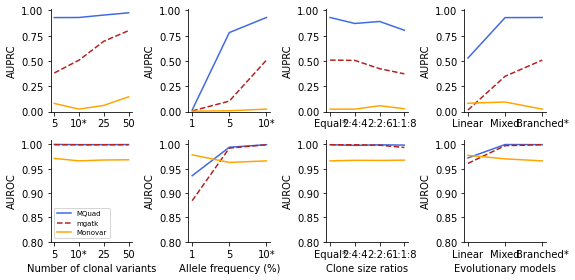

In [9]:
# ROC
#mgatk.dropna(inplace=True)

n_mut = [5, 10, 25, 50]
str_n_mut = ['5', '10*', '25', '50']
af_pct = [1, 5, 10]
str_af_pct = ['1', '5', '10*']
sizes = [None, '244', '226', '118']
str_sizes = ['Equal*', '2:4:4', '2:2:6', '1:1:8']
tree = ['linear', 'branched', None]
str_tree = ['Linear', 'Mixed', 'Branched*']

def get_auc(vartype_list, n=10, a=10, s=None, t=None):
    auroc_mquad, auroc_mgatk, auroc_monovar = [],[],[]
    auprc_mquad, auprc_mgatk, auprc_monovar = [],[],[]
    
    def foo():
        mgatk = process_mgatk_data(n, a, s, t)
        mquad = process_mquad_data(n, a, s, t)
        merged_with_mquad = process_monovar_data(n, a, s, t)

        auroc_mquad.append(calculate_metrics(mquad.truth, mquad.deltaBIC)[2])
        auroc_mgatk.append(calculate_metrics(mgatk.truth, mgatk.vmr)[2])
        auroc_monovar.append(calculate_metrics(merged_with_mquad.truth, merged_with_mquad.MPR)[2])

        auprc_mquad.append(calculate_metrics(mquad.truth, mquad.deltaBIC)[5])
        auprc_mgatk.append(calculate_metrics(mgatk.truth, mgatk.vmr)[5])
        auprc_monovar.append(calculate_metrics(merged_with_mquad.truth, merged_with_mquad.MPR)[5])

    if vartype_list == "n_mut":
        for n in n_mut:
            foo()
    elif vartype_list == "af_pct":
        for a in af_pct:
            foo()
    elif vartype_list == "sizes":
        for s in sizes:
            foo()
    elif vartype_list == "tree":
        for t in tree:
            foo()
            
    return auroc_mquad, auroc_mgatk, auroc_monovar, auprc_mquad, auprc_mgatk, auprc_monovar

def plot_comparison(xticks, mquad, mgatk, monovar, xlab, ylab, legend=False):
    plt.plot(xticks, mquad, label="MQuad", color="royalblue")
    plt.plot(xticks, mgatk, label="mgatk", linestyle='--', color="firebrick")
    plt.plot(xticks, monovar, label="Monovar", color="orange")
    plt.xlabel(xlab)
    plt.ylabel(ylab)

    if legend:
        plt.legend(loc='lower left', prop={'size': 7})

    if ylab == "AUPRC":
        plt.ylim((0,1.01))
    elif ylab == "AUROC":
        plt.ylim((0.8,1.01))

fig = plt.figure(figsize=(8, 4))
plt.subplot(2,4,1)
auroc_mquad, auroc_mgatk, auroc_monovar, auprc_mquad, auprc_mgatk, auprc_monovar = get_auc("n_mut")
plot_comparison(str_n_mut, auprc_mquad, auprc_mgatk, auprc_monovar, None, "AUPRC")

plt.subplot(2,4,5)
plot_comparison(str_n_mut, auroc_mquad, auroc_mgatk, auroc_monovar, 'Number of clonal variants', 'AUROC', legend=True)

plt.subplot(2,4,2)
auroc_mquad, auroc_mgatk, auroc_monovar, auprc_mquad, auprc_mgatk, auprc_monovar = get_auc("af_pct")
plot_comparison(str_af_pct, auprc_mquad, auprc_mgatk, auprc_monovar, None, "AUPRC")

plt.subplot(2,4,6)
plot_comparison(str_af_pct, auroc_mquad, auroc_mgatk, auroc_monovar, 'Allele frequency (%)', 'AUROC')

plt.subplot(2,4,3)
auroc_mquad, auroc_mgatk, auroc_monovar, auprc_mquad, auprc_mgatk, auprc_monovar = get_auc("sizes")
plot_comparison(str_sizes, auprc_mquad, auprc_mgatk, auprc_monovar, None, "AUPRC")

plt.subplot(2,4,7)
plot_comparison(str_sizes, auroc_mquad, auroc_mgatk, auroc_monovar, 'Clone size ratios', 'AUROC')

plt.subplot(2,4,4)
auroc_mquad, auroc_mgatk, auroc_monovar, auprc_mquad, auprc_mgatk, auprc_monovar = get_auc("tree")
plot_comparison(str_tree, auprc_mquad, auprc_mgatk, auprc_monovar, None, "AUPRC")

plt.subplot(2,4,8)
plot_comparison(str_tree, auroc_mquad, auroc_mgatk, auroc_monovar, 'Evolutionary models', 'AUROC')

plt.tight_layout()

#plt.savefig('figures/all_comparisons.pdf')

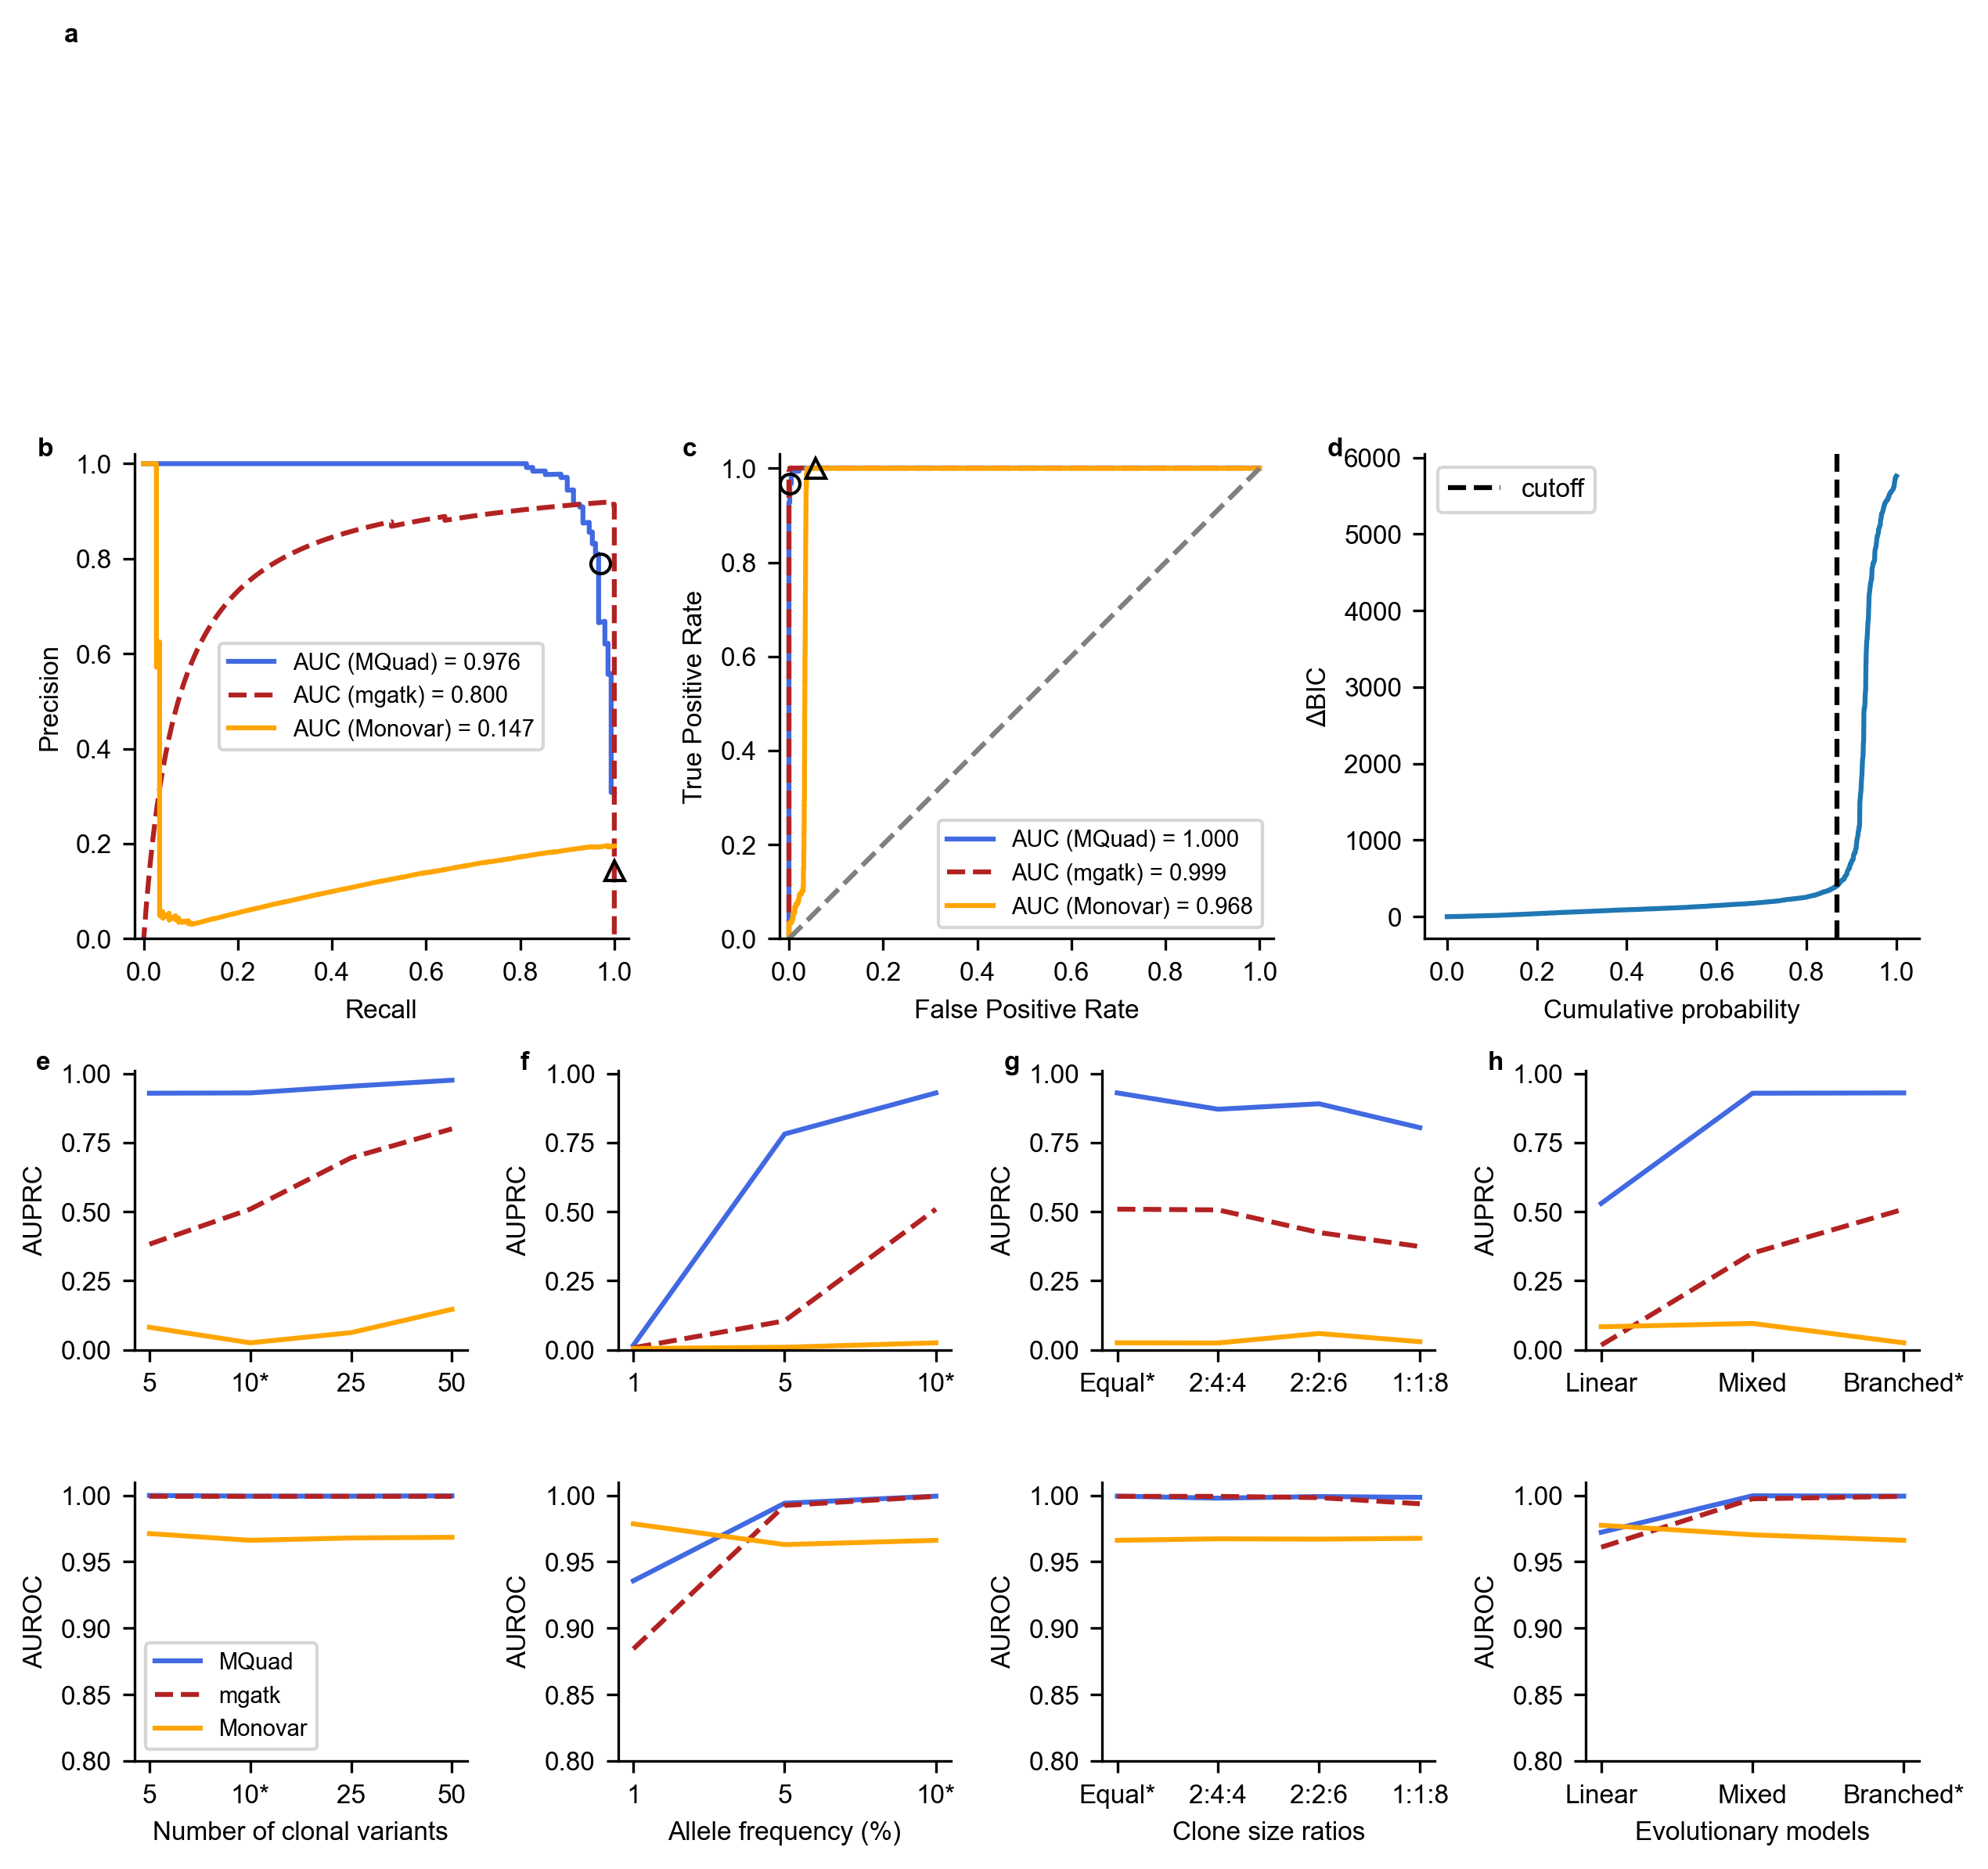

In [34]:
plt.style.use('default')
font = {'family' : 'Arial',
        'size'   : 8}
plt.rc('font', **font)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
cm = 1/2.54
fig = plt.figure(figsize=(8.5,8), dpi=300)

##leave some empty space on top for Fig. 1a

empty_ax = plt.subplot2grid((9,12), (0,0), rowspan=2, colspan=12)
empty_ax.text(-0.1*cm, 2.5*cm, 'a', transform = empty_ax.transAxes, fontsize = 8, fontweight = 'bold', va='bottom', ha='left')
empty_ax.axis('off')

ax1 = plt.subplot2grid((9,12), (2, 0), rowspan=3, colspan=4)
ax1.text(-0.5*cm, 2.5*cm, 'b', transform = ax1.transAxes, fontsize = 8, fontweight = 'bold', va='bottom', ha='left')

mquad = process_mquad_data(50,10)
mgatk = process_mgatk_data(50,10)
merged_with_mquad = process_monovar_data(50,10)

fpr_mquad, tpr_mquad, auc_mquad, precision_mquad, recall_mquad, aps_mquad = calculate_metrics(mquad.truth, mquad.deltaBIC)
fpr_mgatk, tpr_mgatk, auc_mgatk, precision_mgatk, recall_mgatk, aps_mgatk = calculate_metrics(mgatk.truth, mgatk.vmr)
fpr_mono, tpr_mono, auc_mono, precision_mono,recall_mono, aps_mono = calculate_metrics(merged_with_mquad.truth, merged_with_mquad.MPR)

plot_figure_1b()

ax2 = plt.subplot2grid((9,12), (2, 4), rowspan=3, colspan=4)
ax2.text(-0.5*cm, 2.5*cm, 'c', transform = ax2.transAxes, fontsize = 8, fontweight = 'bold', va='bottom', ha='left')
plot_figure_1c()

ax3 = plt.subplot2grid((9,12), (2, 8), rowspan=3, colspan=4)
ax3.text(-0.5*cm, 2.5*cm, 'd', transform = ax3.transAxes, fontsize = 8, fontweight = 'bold', va='bottom', ha='left')
plot_figure_1d()

ax4 = plt.subplot2grid((9,12), (5, 0), rowspan=2, colspan=3)
ax4.text(-0.75*cm, 2.5*cm, 'e', transform = ax4.transAxes, fontsize = 8, fontweight = 'bold', va='bottom', ha='left')
auroc_mquad, auroc_mgatk, auroc_monovar, auprc_mquad, auprc_mgatk, auprc_monovar = get_auc("n_mut")
plot_comparison(str_n_mut, auprc_mquad, auprc_mgatk, auprc_monovar, None, "AUPRC")

ax5 = plt.subplot2grid((9,12), (7, 0), rowspan=2, colspan=3)
plot_comparison(str_n_mut, auroc_mquad, auroc_mgatk, auroc_monovar, 'Number of clonal variants', 'AUROC', legend=True)

ax6 = plt.subplot2grid((9,12), (5, 3), rowspan=2, colspan=3)
ax6.text(-0.75*cm, 2.5*cm, 'f', transform = ax6.transAxes, fontsize = 8, fontweight = 'bold', va='bottom', ha='left')
auroc_mquad, auroc_mgatk, auroc_monovar, auprc_mquad, auprc_mgatk, auprc_monovar = get_auc("af_pct")
plot_comparison(str_af_pct, auprc_mquad, auprc_mgatk, auprc_monovar, None, "AUPRC")

ax7 = plt.subplot2grid((9,12), (7, 3), rowspan=2, colspan=3)
plot_comparison(str_af_pct, auroc_mquad, auroc_mgatk, auroc_monovar, 'Allele frequency (%)', 'AUROC')

ax8 = plt.subplot2grid((9,12), (5, 6), rowspan=2, colspan=3)
ax8.text(-0.75*cm, 2.5*cm, 'g', transform = ax8.transAxes, fontsize = 8, fontweight = 'bold', va='bottom', ha='left')
auroc_mquad, auroc_mgatk, auroc_monovar, auprc_mquad, auprc_mgatk, auprc_monovar = get_auc("sizes")
plot_comparison(str_sizes, auprc_mquad, auprc_mgatk, auprc_monovar, None, "AUPRC")

ax9 = plt.subplot2grid((9,12), (7, 6), rowspan=2, colspan=3)
plot_comparison(str_sizes, auroc_mquad, auroc_mgatk, auroc_monovar, 'Clone size ratios', 'AUROC')

ax10 = plt.subplot2grid((9,12), (5, 9), rowspan=2, colspan=3)
ax10.text(-0.75*cm, 2.5*cm, 'h', transform = ax10.transAxes, fontsize = 8, fontweight = 'bold', va='bottom', ha='left')
auroc_mquad, auroc_mgatk, auroc_monovar, auprc_mquad, auprc_mgatk, auprc_monovar = get_auc("tree")
plot_comparison(str_tree, auprc_mquad, auprc_mgatk, auprc_monovar, None, "AUPRC")

ax11 = plt.subplot2grid((9,12), (7, 9), rowspan=2, colspan=3)
plot_comparison(str_tree, auroc_mquad, auroc_mgatk, auroc_monovar, 'Evolutionary models', 'AUROC')

plt.tight_layout()

plt.savefig('figures/Fig1_tmp.svg')
